# LABEL DETECTION
- Within this notebook we will use the Google Vision API to scan image files
- Once each image is scanned it will return 10 labels for each image that are key words that describe what is in the picture
- Prior to feeding the Google Vision API the images, the images must be separated into **Flood** and **No Flood** directories
- [Google Vision](https://cloud.google.com/vision): Follow this link to install the Google Vision SDK

In [4]:
# Install & Upgrade Google Vision API
# pip install --upgrade google-cloud-vision

In [5]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import io
import os

from google.cloud import vision
from google.cloud.vision import types
from google.oauth2 import service_account # https://github.com/googleapis/google-cloud-python/issues/5349 - need this in order access API
                                          # enter your JSON file in the path after you have created your service account
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB # , GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# from sklearn.ensemble import VotingClassifier
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.naive_bayes import GaussianNB

## Google API Credentials

In [6]:
# Set your Google API credentials_path to a variable
credentials_path = "./flood-car-classifier-3de49495f20b.json"

# Set up credentials variable to communicate with your service account
credentials = service_account.Credentials. from_service_account_file(credentials_path)

## Image Directory Path Setup

In [22]:
# Set up the flooded and non flooded image directory
flood_directory_path = './data/images_for_labeling/flood/'
noflood_directory_path = './data/images_for_labeling/noflood/'

In [23]:
flood = []
for i in os.listdir(flood_directory_path):
    if i == '.DS_Store' or i == '.ipynb_checkpoints':
        pass
    else:
        flood.append(i)
        
noflood = []
for i in os.listdir(noflood_directory_path):
    if i == '.DS_Store' or i == '.ipynb_checkpoints':
        pass
    else:
        noflood.append(i)

In [24]:
# preview flood lists for labeling function
print(flood[0:5])
print()
print(noflood[0:5])


['flood_64.jpg', 'flood_70.jpg', 'flood_58.jpg', 'flood_103.jpg', 'flood_117.jpg']

['no_flood_94.jpg', 'no_flood_102.jpg', 'no_flood_80.jpg', 'no_flood_57.jpg', 'no_flood_43.jpg']


## Label Detection Function

In [27]:
# formula inspired by https://cloud.google.com/vision/docs/labels

# PARAMETER 'list_name' - this should be 'flood' or 'noflood' variable
# PARAMETER 'image_directory_path' - this should be 'flood_directory_path' or 'noflood_directory_path' variable

def image_labeler(list_name, image_directory_path):
    
    # Create dictionary for image filename & image labels
    image_dict = {}
    
    for file in list_name:
    
        # Instantiates a client
        client = vision.ImageAnnotatorClient(credentials=credentials)

        # The name of the image file to annotate
        file_name = os.path.abspath(image_directory_path + file)

        # Loads the image into memory
        with io.open(file_name, 'rb') as image_file:
            content = image_file.read()

        image = types.Image(content=content)

        # Performs label detection on the image file
        response = client.label_detection(image=image)
        labels = response.label_annotations
        
        # Create list of image labels
        image_list = []
        
        # Loop through each images assigned labels
        for label in labels:
            image_list.append(label.description)
        
        # Add image filename & labels to dictionary
        image_dict[flood_directory_path + file] = image_list
        
        # Create DF from results
        image_df = pd.DataFrame(image_dict.items(), columns=['filename', 'labels'])
        image_df['flood_in_image'] = str(list_name)
        
        # Create Y target Column
        if 'noflood' in image_directory_path:
            image_df['flood_in_image'] = 0
        elif 'flood' in image_directory_path:
            image_df['flood_in_image'] = 1
        else:
            pass
        
        # Prepare X column for pre-processing
        image_df['labels'] = image_df['labels'].apply(lambda x: ", ".join(x).lower())
        
    return image_df

## Create Dataframe

In [28]:
# Create FLOOD df by running the function and saving to a variable
flood_df = image_labeler(flood, flood_directory_path)
flood_df.head()

,filename,labels,flood_in_image
0,./data/images_for_labeling/flood/flood_64.jpg,"land vehicle, vehicle, car, city car, compact ...",1
1,./data/images_for_labeling/flood/flood_70.jpg,"water, vehicle, reflection, rain, car, puddle,...",1
2,./data/images_for_labeling/flood/flood_58.jpg,"land vehicle, vehicle, car, automotive design,...",1
3,./data/images_for_labeling/flood/flood_103.jpg,"vehicle, car, compact car, supermini, crossove...",1
4,./data/images_for_labeling/flood/flood_117.jpg,"vehicle, car, waterway, flood, water resources...",1


In [29]:
# Create NO FLOOD df by running the function and saving to a variable
noflood_df = image_labeler(noflood, noflood_directory_path)
noflood_df.head()

,filename,labels,flood_in_image
0,./data/images_for_labeling/flood/no_flood_94.jpg,"land vehicle, vehicle, car, luxury vehicle, au...",0
1,./data/images_for_labeling/flood/no_flood_102.jpg,"land vehicle, vehicle, car, motor vehicle, aut...",0
2,./data/images_for_labeling/flood/no_flood_80.jpg,"land vehicle, vehicle, car, motor vehicle, min...",0
3,./data/images_for_labeling/flood/no_flood_57.jpg,"land vehicle, vehicle, car, motor vehicle, aut...",0
4,./data/images_for_labeling/flood/no_flood_43.jpg,"land vehicle, vehicle, tire, car, automotive t...",0


In [30]:
# Quick DF concatenation function
def combine_df(dataframe1, dataframe2):
    df = pd.concat([dataframe1, dataframe2], axis=0).reset_index().drop(columns='index')
    return df

In [31]:
# Combine FLOOD & NO FLOOD dataframe into one DF
df = combine_df(flood_df, noflood_df)
print(df.shape)
df.head()

(229, 3)


,filename,labels,flood_in_image
0,./data/images_for_labeling/flood/flood_64.jpg,"land vehicle, vehicle, car, city car, compact ...",1
1,./data/images_for_labeling/flood/flood_70.jpg,"water, vehicle, reflection, rain, car, puddle,...",1
2,./data/images_for_labeling/flood/flood_58.jpg,"land vehicle, vehicle, car, automotive design,...",1
3,./data/images_for_labeling/flood/flood_103.jpg,"vehicle, car, compact car, supermini, crossove...",1
4,./data/images_for_labeling/flood/flood_117.jpg,"vehicle, car, waterway, flood, water resources...",1


In [32]:
# Save Dataframe
df.to_csv('./data/step_1_data.csv')
print(df.shape)
df.head()

(229, 3)


,filename,labels,flood_in_image
0,./data/images_for_labeling/flood/flood_64.jpg,"land vehicle, vehicle, car, city car, compact ...",1
1,./data/images_for_labeling/flood/flood_70.jpg,"water, vehicle, reflection, rain, car, puddle,...",1
2,./data/images_for_labeling/flood/flood_58.jpg,"land vehicle, vehicle, car, automotive design,...",1
3,./data/images_for_labeling/flood/flood_103.jpg,"vehicle, car, compact car, supermini, crossove...",1
4,./data/images_for_labeling/flood/flood_117.jpg,"vehicle, car, waterway, flood, water resources...",1


### Which Model Should I Use?
<img src="https://scikit-learn.org/stable/_static/ml_map.png" style="float: ; margin: 160px; height: 440px">

## Modeling

In [34]:
# Set up X & y variable
X = df.labels
y = df.flood_in_image

# Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2020)

# Transformer Setup & fit
cv = CountVectorizer()
cv.fit(X_train)

# Transform Data
Z_train = cv.transform(X_train)
Z_test = cv.transform(X_test)

In [35]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(Z_train, y_train)

print(f'Cross Validation Score: {cross_val_score(LogisticRegression(), Z_train, y_train, cv=5).mean()}')
print(f'Training Score: {logreg.score(Z_train, y_train)}')
print(f'Testing Score: {logreg.score(Z_test, y_test)}')

Cross Validation Score: 0.8769747899159663
Training Score: 0.9707602339181286
Testing Score: 0.8103448275862069


In [36]:
# LinearSVC
svc = LinearSVC()
svc.fit(Z_train, y_train)

print(f'Cross Validation Score: {cross_val_score(LinearSVC(), Z_train, y_train, cv=5).mean()}')
print(f'Training Score: {svc.score(Z_train, y_train)}')
print(f'Testing Score: {svc.score(Z_test, y_test)}')

Cross Validation Score: 0.8539495798319328
Training Score: 1.0
Testing Score: 0.7586206896551724


In [37]:
# MultinomialNB
mnb = MultinomialNB()
mnb.fit(Z_train, y_train)

print(f'Cross Validation Score: {cross_val_score(MultinomialNB(), Z_train, y_train, cv=5).mean()}')
print(f'Training Score: {mnb.score(Z_train, y_train)}')
print(f'Testing Score: {mnb.score(Z_test, y_test)}')

Cross Validation Score: 0.8536134453781511
Training Score: 0.8947368421052632
Testing Score: 0.8793103448275862


In [45]:
# Baseline Score
print(f'Baseline Metric to beat: {round(df.flood_in_image.value_counts(normalize=True)[1], 4)*100}%')
df.flood_in_image.value_counts(normalize=True)

Baseline Metric to beat: 54.15%


1    0.541485
0    0.458515
Name: flood_in_image, dtype: float64

In [46]:
# Model Predictions on Test Data
y_pred = mnb.predict(Z_test)
y_pred

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0])

## Visualize and Interpret Results

-----------------False------------------
(0,0) True Negative - 26
(0,1) False Positive - 1
------------------True------------------
(1,0) False Negative - 6
(1,1) True Positive - 25

Accuracy: 87.931% - (1) Correct Predictions / ALL predictions
---------------------------------------------------------------------------------------
Specificity: 96.2963% - (0) Correctly Predicted NO FLOODING / ALL NO FLOODING images
---------------------------------------------------------------------------------------
Sensitivity: 80.6452% - (1) Correctly Predicted FLOODING / ALL FLOODING images
---------------------------------------------------------------------------------------
Precision: 96.1538% - (1) Correctly Predicted FLOODING / ALL FLOODING predictions
---------------------------------------------------------------------------------------


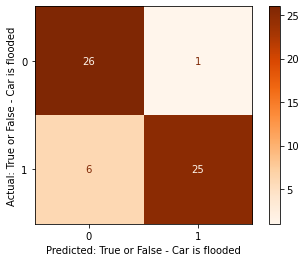

In [78]:
# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Plot
plot_confusion_matrix(mnb, Z_test, y_test, cmap='Oranges', values_format='d');
plt.xlabel('Predicted: True or False - Car is flooded')
plt.ylabel('Actual: True or False - Car is flooded');

# For easy consumption
print('False'.center(40, "-"))
print(f'(0,0) True Negative - {tn}')
print(f'(0,1) False Positive - {fp}')
print('True'.center(40, "-"))
print(f'(1,0) False Negative - {fn}')
print(f'(1,1) True Positive - {tp}')
print()

# Model Prediction
accu = (tn + tp) / (tn + tp + fn + fp)
print(f'Accuracy: {round(accu * 100, 4)}% - (1) Correct Predictions / ALL predictions')
print('---------------------------------------------------------------------------------------')

# Calculate the specificity
spec = tn / (tn + fp)
print(f'Specificity: {round(spec * 100, 4)}% - (0) Correctly Predicted NO FLOODING / ALL NO FLOODING images')
print('---------------------------------------------------------------------------------------')

# Sensitivity
sens = tp / (tp + fn)
print(F'Sensitivity: {round(sens * 100, 4)}% - (1) Correctly Predicted FLOODING / ALL FLOODING images')
print('---------------------------------------------------------------------------------------')

# Precision
prec = tp / (tp + fp)
print(f'Precision: {round(prec * 100, 4)}% - (1) Correctly Predicted FLOODING / ALL FLOODING predictions')
print('---------------------------------------------------------------------------------------')

### Interpreting Results
- We were able to determine if the image contained flooding or no flooding with 87.9% accuracy leveraging a Multinomial Naive Bayes model
- With specificity coming in at 80.6% we hope to minimize FALSE NEGATIVES in order to ensure we do not miss any floods where the insurance company should be involved.


# Next Steps

In [103]:
# Append precictions to Dataframe and save list of flooded images to new directory

In [209]:
# # Set Up Pipes
# lr_pipe = Pipeline([
#     ('cv', CountVectorizer()),
#     ('logreg', LogisticRegression(solver='liblinear', random_state=2020)),
# ])

# mnb_pipe = Pipeline([
#     ('cv', CountVectorizer()),
#     ('mnb', MultinomialNB()),
# ])
# svc_pipe = Pipeline([
#     ('cv', CountVectorizer()),
#     ('svc', LinearSVC(random_state=2020)),
# ])

In [210]:
# # Set Up Params
# lr_pipe.get_params()
# lr_pipe_params = {
#     'cv__max_df': [1.0],
#     'cv__max_features': [None],
#     'cv__min_df': [1],
#     'cv__ngram_range': [(1, 1)],
#     'logreg__C': [1.0],
#     'logreg__class_weight': [None],
#     'logreg__max_iter': [100],
# #     'logreg__solver': ['lbfgs'],  
# }

# mnb_pipe.get_params()
# mnb_pipe_params = {
#     'cv__max_df': [1.0],
#     'cv__max_features': [None],
#     'cv__min_df': [1],
#     'cv__ngram_range': [(1, 1)],
#     'mnb__alpha': [1.0, 0.1, 0.01, .0001],
# }

# svc_pipe.get_params()
# svc_pipe_params = {
#     'cv__max_df': [1.0],
#     'cv__max_features': [None],
#     'cv__min_df': [1],
#     'cv__ngram_range': [(1, 1)],
#     'svc__C': [1.0],
#     'svc__class_weight': [None],
# }

In [211]:
# # gridsearch
# # gs_lr = GridSearchCV(lr_pipe, lr_pipe_params, n_jobs = -1, cv = 5, verbose = 2)
# # gs_lr.fit(X_train, y_train)

# gs_mnb = GridSearchCV(mnb_pipe, mnb_pipe_params, n_jobs = -1, cv = 5, verbose = 2)
# gs_mnb.fit(X_train, y_train)

# # gs_svc = GridSearchCV(svc_pipe, svc_pipe_params, n_jobs = -1, cv = 5, verbose = 2)
# # gs_svc.fit(X_train, y_train)